## <font color='darkblue'>Preface</font>
([article source](https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da)) <b><font size='3ptx'>A Gentle Introduction to the Classic RL Problem with Python Examples</font></b>

[**Multi-armed bandit problems**](https://en.wikipedia.org/wiki/Multi-armed_bandit) are some of the simplest [**reinforcement learning**](https://en.wikipedia.org/wiki/Reinforcement_learning) (<font color='brown'>RL</font>) problems to solve. We have an agent which we allow to choose actions, and each action has a reward that is returned according to a given, underlying probability distribution. The game is played over many episodes (<font color='brown'>single actions in this case</font>) and <b>the goal is to maximize your reward</b>.

An easy picture is to think of choosing between k-many one-armed bandits (<font color='brown'>i.e. slot machines</font>) or one big slot machine with `k` arms. Each arm you pull has a different reward associated with it. You’re given 1,000 quarters, so you need to develop some kind of strategy to get the most bang for your buck.
> 這個問題，其實是一個經典的思考實驗。因為每個人只有兩隻手臂。一次最多只能拉兩台機器，無法很快地找到（自認為）勝率較高的機台。而且萬一兩台勝率較高的吃角子老虎機相隔很遠，您也拉不太到。而我們的目標是贏得最多的錢走出賭場。問題在於，您如何在最短時間內，知道哪一台老虎機是最好的，並且贏得最多的錢？ ([source](https://medium.com/marketingdatascience/%E4%BD%95%E8%AC%82%E5%A4%9A%E8%87%82%E5%90%83%E8%A7%92%E5%AD%90%E8%80%81%E8%99%8E%E6%A9%9F%E6%B8%AC%E8%A9%A6-multi-armed-bandit-testing-6e17950a3520))

<b>One way to approach this is to select each one in turn and keep track of how much you received, then keep going back to the one that paid out the most</b>. This is possible, but, as stated before, each bandit has an underlying probability distribution associated with it, meaning that you may need more samples before finding the right one. 

But, each pull you spend trying to figure out the best bandit to play takes you away from maximizing your reward. This basic balancing act is known as the <b><font color='darkblue' size='3ptx'>explore-exploit dilemma</font></b>.

Forms of this basic problem come up in areas outside of AI and RL, such as in [choosing a career](https://joshkaufman.net/explore-exploit/), [finance](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI15/paper/viewFile/10972/10798), [human psychology](https://econ.arizona.edu/sites/econ/files/wilsonetal_jepgeneral2014_print.pdf), and even [medical ethics](http://www.pnas.org/content/106/52/22387) (<font color='brown'>although, I think my favorite proposed use case relates to the suggestion that, due to its richness, it be given to Nazi Germany during WWII, “as the ultimate form of intellectual sabotage.”</font>).

### <font color='darkgreen'>TL;DR</font>
We introduce multi-armed bandit problems following the framework of [Sutton and Barto’s book](https://amzn.to/2Q2mxxn) (affiliate link) and develop a framework for solving these problems as well as examples. In this post, we’ll focus on ϵ−greedy, ϵ−decay, and optimistic strategies. As always, you can find the [original post here](https://www.datahubbs.com/multi_armed_bandits_reinforcement_learning_1/) (<font color='brown'>which properly supports LaTeX</font>).

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'><b><a href='#sect0'>RL Introduction</a></b></font>
* <font size='3ptx'><b><a href='#sect1'>Problem Setup</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>Strategies for solving k-bandit problems</a></b></font>

<a id='sect0'></a>
## <font color='darkblue'>RL Introduction</font>
You've probably heard of programs that defeated human players in Go, chess, and Shogi by using [**reinforcement learning**](https://en.wikipedia.org/wiki/Reinforcement_learning) (RL). This  notebook aims to introduce you the basic of RL and apply what you learn to resolve a classic RL problem - [**Multi-armed bandit problems**](https://en.wikipedia.org/wiki/Multi-armed_bandit).

<a id='sect0_1'></a>
### <font color='darkgreen'>RL framing & components</font>
(<font color='brown'>Source from [RL problem framing](https://colab.corp.google.com/drive/1sUYro4ZyiHuuKfy6KXFSdWjNlb98ZROd?usp=sharing)</font>) Suppose you've moved to a new neighborhood. You're looking for great restaurants in the neighborhood. At first, you explore randomly. Slowly, you begin returning to the restaurants you like. After a while, you tend to stick to the restaurants you like. Through this process, you learned new favorite restaurants through reinforcement from repeated exploration. Reinforcement Learning formalizes this learning process.

For a more concrete example, imagine you're playing [**Pac-Man**](https://en.wikipedia.org/wiki/Pac-Man). You need to eat dots and avoid ghosts. You can frame this scenario in RL as follows:
* Pac-Man is the <font size='3ptx' color='darkblue'>**agent**</font>.
* The maze is the <font size='3ptx' color='darkblue'>**environment**</font>.
* Eating the dots returns <font size='3ptx' color='darkblue'>**rewards**</font>. Failure, such as being eaten by a ghost, is framed as a <font size='3ptx' color='darkblue'>**negative reward**</font>.

If you assign a positive numeric reward to eating the dots, and a negative numeric reward to being eaten, then you can <b>frame Pac-Man's objective as reward maximization</b>.
![Screenshot of the Pac-Man computer game.](https://www.google.com/logos/2010/pacman10-hp.png)

To maximize reward, Pac-Man moves from cell to cell by going up, down, left, and right. In RL, these movements are called <font size='3ptx' color='darkblue'>**actions**</font>. On each action, the position of Pac-Man, the positions of the ghosts, and the available rewards change. Together, these positions and rewards are the environment's <font size='3ptx' color='darkblue'>**state**</font>. <b>Therefore, the state changes on each action . An agent takes an action $a$ in a state $s$ and transitions to another state $s’$ while receiving a reward $r$.</b>
![A simple schematic shows the framework provided by Reinforcement Learning at a high level of abstraction. There are five boxes labeled. The first box, agent, is connected to the third box, environment, through the second box, action. The environment is connected back to the agent through two boxes: state and reward. ](https://developers.google.com/machine-learning/reinforcement-learning/images/rl-framing-outline.png)

Now, let's try mapping out the environment by recording the agent's transitions. Each transition is characterized by the tuple $(s, a, r, s')$.  This sequence of tuples $(s, a, r, s’)$ is the agent’s <font size='3ptx' color='darkblue'>**trajectory**</font>.

$$s_0 \xrightarrow[r_0]{a_0} s_1 \xrightarrow[r_1]{a_1} s_2 \ldots \xrightarrow[r_2]{a_{n-2}} s_{n-1}\xrightarrow[r_{n-1}]{a_{n-1}} s_n
$$

A trajectory from start to termination is called an <font size='3ptx' color='darkblue'>**episode**</font>. The trajectory terminates when the termination condition is met. 

So far we have known:
* Basic RL terminology:
    * [agent](https://developers.google.com/machine-learning/glossary/#agent)
    * [environment](https://developers.google.com/machine-learning/glossary/#environment)
    * [state](https://developers.google.com/machine-learning/glossary/#state), [action](https://developers.google.com/machine-learning/glossary/#action), and [reward](https://developers.google.com/machine-learning/glossary/#reward)
    * [episode](https://developers.google.com/machine-learning/glossary/#episode)
    * [termination condition](https://developers.google.com/machine-learning/glossary/#termination-condition)
* How RL frames problems as state-action-reward frameworks.
* How RL environments are probabilistic.

<a id='sect0_2'></a>
### <font color='darkgreen'>Markov Decision Process</font>
(<font color='brown'>Source From [Q Learning Framework](https://colab.corp.google.com/drive/1ZPsEEu30SH1BUqUSxNsz0xeXL2Aalqfa?usp=sharing)</font>) When an agent makes decisions to navigate a sequence of states under the certain state, then the result is called a [**Markov Decision Process**](https://en.wikipedia.org/wiki/Markov_decision_process) (MDP). Recall that this sequence of states is called a trajectory, represented by $(s,a,r,s')$ tuples as follows:

$$s_0 \xrightarrow[r_0]{a_0} s_1 \xrightarrow[r_1]{a_1} s_2 \ldots \xrightarrow[r_2]{a_{n-2}} s_{n-1}\xrightarrow[r_{n-1}]{a_{n-1}} s_n
$$

<br/>

To run the agent in a loop, you must automatically choose actions. The algorithm that chooses actions is called the <font size='3ptx' color='darkblue'>**policy**</font>. 

Please check [this video - Markov Decision Processes Two - Georgia Tech - Machine Learning](https://www.youtube.com/watch?v=BxIG76-C37k) (5min) to learn more:
![Markov decision process](images/1.PNG)

<a id='sect0_3'></a>
### <font color='darkgreen'>Exploration vs Exploitation</font>
For details, please refer to this [video](https://www.youtube.com/watch?v=Xe28DvYvf-M) (4mins). Basic idea here is to leverage <font color='darkblue' size='3ptx'>**Exploration**</font> to discover all possible states and their corresponding rewarding so we can apply <font color='darkblue' size='3ptx'>**Exploitable**</font> to maximum our final rewarding:

* **Exploration**
    * Find out more about the Environment
    * Give up some immediate Rewards for maximizing Future Regards
* **Exploitation**
    * Exploit known or Profitable Information about Environment to maximize immediate Regards.
    
<br/>

We can apply this idea to many situations:
* **Advertising:**
    * Exploitation: Showing same profitable ads repeatedly.
    * Exploration: Showing new ads which may be more profitable.
* **Restaurant:**
    * Exploitation: Going to the same favorite restaurant
    * Exploration: Trying out new restaurants
    
<br/>   

![Exploration vs Exploitation](images/2.PNG)          

([image source](https://www.linkedin.com/pulse/battle-exploration-exploitation-mindset-abhishek-singh/))

<a id='sect0_4'></a>
### <font color='darkgreen'>Bellman Equation</font>
([content source](https://medium.com/analytics-vidhya/bellman-equation-and-dynamic-programming-773ce67fc6a7)) <b><font size='3ptx'>If you have read anything related to reinforcement learning you must have encountered [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) somewhere</font></b>. 

<b>Bellman equation is the basic block of solving reinforcement learning and is omnipresent in RL. It helps us to solve [MDP](#sect0_2)</b>. To solve means finding the optimal policy and value functions.

The optimal value function $V^π(s)$ is one that yields maximum value:
> $V^π(s) = max_a(R(s,a) + γ(V^π(s')))$

* $V^π(s)$ : Value function of specific version agent π.
* $R(s,a)$ : Reward function to return reward based on given state `s` after taking action `a`
* $γ$: Decay factor ( $1 > γ > 0$)

<br/>

You can refer below links for more explanation of Bellman Equation:
* [The Bellman Equations - 1](https://www.youtube.com/watch?v=b1GvQcjDwBU)
* [The Bellman Equations - 2](https://www.youtube.com/watch?v=aHQ3qkr51X8)
* [The Bellman Equations - 3](https://www.youtube.com/watch?v=XLkW_WGJoyQ)

<a id='sect1'></a>
## <font color='darkblue'>Problem Setup</font>
To get started, let’s describe the problem in a bit more technical detail. What we wish to do, is develop an estimate $Qt​(a)$:
![formula](https://miro.medium.com/max/786/1*n6jigGk161weIu8xHYQT_A.png)

Where $Qt(a)$ is the estimated, expected reward ($Rn$​), when action $An$​ is taken at step `n`. We’re going to iteratively build a model that will converge towards the true value of each action. We’re going to use a Gaussian (<font color='brown'>normal</font>) distribution for all of the underlying probability distributions that we’ll explore so that the mean corresponds to the true value (<font color='brown'>after all, given enough samples, we would expect our rewards to converge to the mean of the selected action</font>).

<b>The simplest way to proceed is to take the <font color='darkblue' size='3ptx'>greedy action</font> or take the action we think will maximize our reward at each time step</b>. Another way of writing this is:
![greedy formula](https://miro.medium.com/max/640/1*S3nJWVy8oQE0gTDnh2D0jw.png)

We can denote this maximum expectation or greedy action as $A*n$. This is the <font size='3ptx'><b>exploit side</b></font> of our aforementioned <b><font size='3ptx' color='blue'>explore-exploit dilemma</font></b>, and it makes lots of sense if the goal is to maximize our reward. Of course, doing this repeatedly only works well once we have a good sense of our expected rewards for each actions (<font color='brown'>unless we get rather lucky</font>). So, <b>we need to figure out an algorithm that explores enough of our search space so that we can exploit the best actions</b>.

Before jumping into this, there’s one last concept to introduce. In typical RL applications, we may need hundreds of thousands of iterations, if not millions or more. It quickly becomes very computationally intensive to run simulations of these sorts and keep track of all that data just to calculate the average reward. To avoid this, we can use a handy formula so that all we need to track are two values: the mean and number of steps taken. If we need to calculate the mean at step `n`, `m_n`, we can do it with the previous mean, `m_n−1`​ and `n` as follows:
![mean formula](https://miro.medium.com/max/786/1*IGzEQ2Ze5N6ijgApE-Tynw.png)

For example:

In [1]:
from datetime import datetime
import random

value_list = [1, 2, 3]
current_mean = sum(value_list) / len(value_list)
print(f'Current mean={current_mean}')

Current mean=2.0


In [2]:
new_values_to_add_and_calculate_mean = [random.randrange(2, 20) for _ in range(50000)]

In [3]:
def approach_O_n(value_list, new_values_to_add_and_calculate_mean):
    st = datetime.now()
    mean_list = []
    for v in new_values_to_add_and_calculate_mean:
        value_list.append(v)
        mean_list.append(sum(value_list) / len(value_list))
        
    print(f'Total time: {datetime.now() - st}')
    return mean_list

def approach_O_1(value_list, new_values_to_add_and_calculate_mean):
    st = datetime.now()
    current_mean = sum(value_list) / len(value_list)    
    mean_list = []
    n = len(value_list)
    for v in new_values_to_add_and_calculate_mean:
        n += 1
        current_mean = current_mean + (v - current_mean) / n
        mean_list.append(current_mean)
    print(f'Total time: {datetime.now() - st}')
    return mean_list

In [4]:
a1_mean_list = approach_O_n(value_list.copy(), new_values_to_add_and_calculate_mean)
list(map(lambda v: round(v, 2), a1_mean_list[:10]))

Total time: 0:00:05.768187


[3.5, 4.4, 6.0, 7.57, 6.88, 8.11, 8.0, 7.73, 7.33, 7.38]

In [5]:
a1_mean_list = approach_O_1(value_list.copy(), new_values_to_add_and_calculate_mean)
list(map(lambda v: round(v, 2), a1_mean_list[:10]))

Total time: 0:00:00.011837


[3.5, 4.4, 6.0, 7.57, 6.88, 8.11, 8.0, 7.73, 7.33, 7.38]

With that, we can start to develop strategies for solving our k-bandit problems.

<a id='sect2'></a>
## <font color='darkblue'>Strategies for solving k-bandit problems</font>
* <font size='3ptx'><b><a href='#sect2_1'>ϵ-Greedy Methods</a></b></font>
* <font size='3ptx'><b><a href='#sect2_2'>ϵ-Decay Strategies</a></b></font>
* <font size='3ptx'><b><a href='#sect2_3'>Optimistic Initial Value</a></b></font>

([content source](https://towardsdatascience.com/solving-the-multi-armed-bandit-problem-b72de40db97c)) [**The multi-armed bandit problem**](https://en.wikipedia.org/wiki/Multi-armed_bandit) is a classic reinforcement learning example where we are given a slot machine with `n` arms (<font color='brown'>bandits</font>) with each arm having its own rigged probability distribution of success. Pulling any one of the arms gives you a stochastic reward of either R=+1 for success, or R=0 for failure. Our objective is to pull the arms one-by-one in sequence such that we maximize our total reward collected in the long run.

![The multi-armed Bandit problem](images/3.PNG)

Here we are going to introduce a few approaches to resolve this problem.

In [6]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

import rl_bandit_utils
%matplotlib inline

iters = 1000
episodes = 1000
k = 10

<a id='sect2_1'></a>
### <font color='darkgreen'>ϵ-Greedy Methods</font>
We briefly talked about a pure-greedy method, and I indicated that on its own it won’t work very well. Consider if you implement a pure-greedy method, you take one action, $A_n=a_1$​, at `n=1` and get a reward. Well, then this becomes your highest reward (<font color='brown'>assuming it is positive</font>) and you simply repeat $a_1 ​∀ n$ (<font color='brown'>take action $a_1$​ for all steps `n`</font>). <b>To encourage a bit of exploration, we can use <font color='darkblue' size='3ptx'>ϵ-greedy</font> which means that we explore another option with a probability of ϵ</b>. This provides a bit of noise into the algorithm to ensure you keep trying other values, otherwise, you keep on exploiting your maximum reward.

Let’s turn to Python to implement our k-armed bandit.

#### <font size='3ptx'>Building a greedy k-Armed Bandit</font>
We’re going to define a class called **eps_bandit** to be able to run our experiment. This class takes number of arms `k`, epsilon value `eps`, number of iterations `iter` as inputs. We'll also define a term `mu` that we can use to adjust the average rewards of each of the arms.

We define class <b><font color='blue'>KArmsBandit</font></b> in module `rl_bandit_utils` to represent K-arms bandit machine. By default, the average rewards for each arm are drawn from a normal distribution around 0. Setting `mu="sequence"` will cause the rewards to range from 0 to k-1 to make it easy to know which actions provide the best rewards when evaluating the results and which actions were taken. Finally, you could also set your own average rewards by passing values to `mu`.

In [7]:
# Define a 10 arms bandit machine
karm_bandit_machine = rl_bandit_utils.KArmsBandit(k, mu='random')

In [8]:
# Pull nth bandit and get reward:
for i in range(k):
    reward = karm_bandit_machine.pull(i)
    print(f'Pull {i}-th arm and get reward={round(reward, 2)}')

Pull 0-th arm and get reward=0.61
Pull 1-th arm and get reward=1.1
Pull 2-th arm and get reward=-0.54
Pull 3-th arm and get reward=-0.74
Pull 4-th arm and get reward=0.89
Pull 5-th arm and get reward=1.08
Pull 6-th arm and get reward=-1.25
Pull 7-th arm and get reward=0.76
Pull 8-th arm and get reward=-2.01
Pull 9-th arm and get reward=0.53


We define class <font color='blue'><b>EPSBandit</b></font> in module `rl_bandit_utils`:
```python
class EPSBandit:
  '''
  Epsilon-greedy k-bandit problem

  Attributes:
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    karms_bandit_machine: K-arms bandit macihne.
  '''
  ...
```

There are plenty of different ways to define this class. I did it so that once we initialize our problem, we just call the <font color='blue'>run()</font> method and can examine the outputs.

Let’s set up some comparisons using different values of `ϵ` (<font color='brown'>epsilon or </font><font color='blue'>self.eps</font>):
```python
    # Generate random number
    p = np.random.rand()
    if self.eps == 0 and self.n == 0:
      # For first time to pull bandit, do it randomly.
      a = np.random.choice(self.k)
    elif p < self.eps:
      # Randomly select an action/arm
      a = np.random.choice(self.k)
    else:
      # Take greedy action
      a = np.argmax(self.k_reward)

    reward = self.karms_bandit_machine.pull(a)
```


For each of these, we’ll set `k=10`, run 1,000 steps for each episode and run 1,000 episodes. After each episode, we will reset the bandits and copy the averages across the different bandits to keep things consistent.

In [9]:
eps_0_rewards = np.zeros(episodes)
eps_01_rewards = np.zeros(episodes)
eps_1_rewards = np.zeros(episodes)

# Initialize bandits
eps_0 = rl_bandit_utils.EPSBandit(eps=0, iters=iters, karms_bandit_machine=karm_bandit_machine)
eps_01 = rl_bandit_utils.EPSBandit(eps=0.01, iters=iters, karms_bandit_machine=karm_bandit_machine)
eps_1 = rl_bandit_utils.EPSBandit(eps=0.1, iters=iters, karms_bandit_machine=karm_bandit_machine)

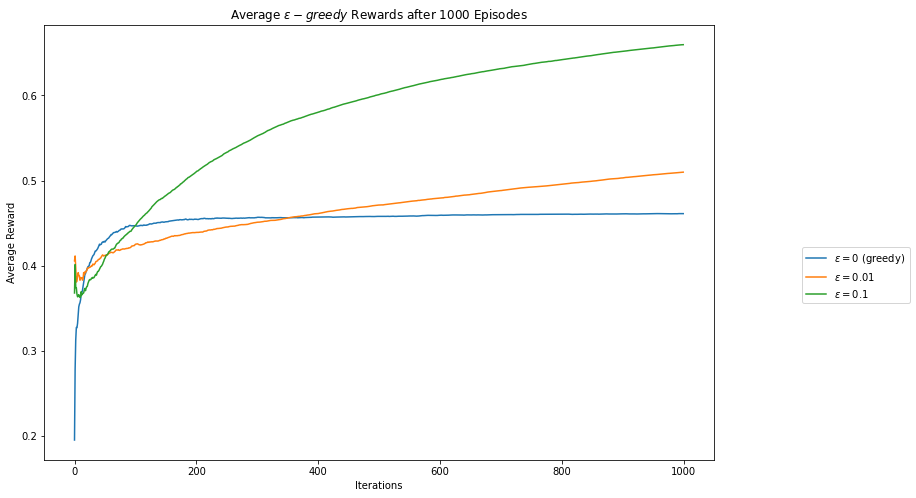

CPU times: user 19.8 s, sys: 219 ms, total: 20 s
Wall time: 19.8 s


In [10]:
%%time
# Run experiments
for i in range(episodes):
  # Run experiments
  eps_0.run()
  eps_01.run()
  eps_1.run()
    
  # Update long-term averages
  eps_0_rewards = eps_0_rewards + (
    eps_0.reward - eps_0_rewards) / (i + 1)
  eps_01_rewards = eps_01_rewards + (
    eps_01.reward - eps_01_rewards) / (i + 1)
  eps_1_rewards = eps_1_rewards + (
    eps_1.reward - eps_1_rewards) / (i + 1)
  
  # Reset bandits
  eps_0.reset()
  eps_01.reset()
  eps_1.reset()
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

Looking at the results, <b>the greedy function under performs the other two consistently, with `ϵ=0.01` coming in between the two and `ϵ=0.1` performing the best of the three here.</b>

Below, we can see the effect is clearer <b>using the `sequence` argument, and can get a feel for how often the optimal action is taken per episode because the averages remain consistent across episodes</b>.

In [11]:
karm_bandit_machine = rl_bandit_utils.KArmsBandit(k, mu='sequence')

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

# Initialize bandits
eps_0 = rl_bandit_utils.EPSBandit(eps=0, iters=iters, karms_bandit_machine=karm_bandit_machine)
eps_01 = rl_bandit_utils.EPSBandit(eps=0.01, iters=iters, karms_bandit_machine=karm_bandit_machine)
eps_1 = rl_bandit_utils.EPSBandit(eps=0.1, iters=iters, karms_bandit_machine=karm_bandit_machine)

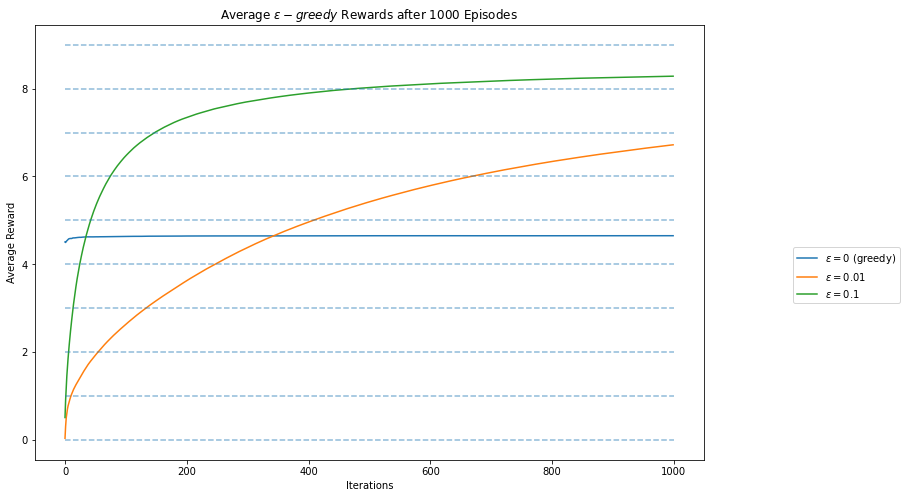

CPU times: user 19.7 s, sys: 200 ms, total: 19.9 s
Wall time: 19.7 s


In [12]:
%%time    
# Run experiments
for i in range(episodes):
  # Run experiments
  eps_0.run()
  eps_01.run()
  eps_1.run()
    
  # Update long-term averages
  eps_0_rewards = eps_0_rewards + (
      eps_0.reward - eps_0_rewards) / (i + 1)
  eps_01_rewards = eps_01_rewards + (
      eps_01.reward - eps_01_rewards) / (i + 1)
  eps_1_rewards = eps_1_rewards + (
      eps_1.reward - eps_1_rewards) / (i + 1)
    
  # Average actions per episode
  eps_0_selection = eps_0_selection + (
      eps_0.k_n - eps_0_selection) / (i + 1)
  eps_01_selection = eps_01_selection + (
      eps_01.k_n - eps_01_selection) / (i + 1)
  eps_1_selection = eps_1_selection + (
      eps_1.k_n - eps_1_selection) / (i + 1)
  
  # Reset bandits
  eps_0.reset()
  eps_01.reset()
  eps_1.reset()
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
for i in range(k):
    plt.hlines(eps_0.karms_bandit_machine.mu[i], xmin=0,
              xmax=iters, alpha=0.5,
              linestyle="--")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + 
     str(episodes) + " Episodes")
plt.show()

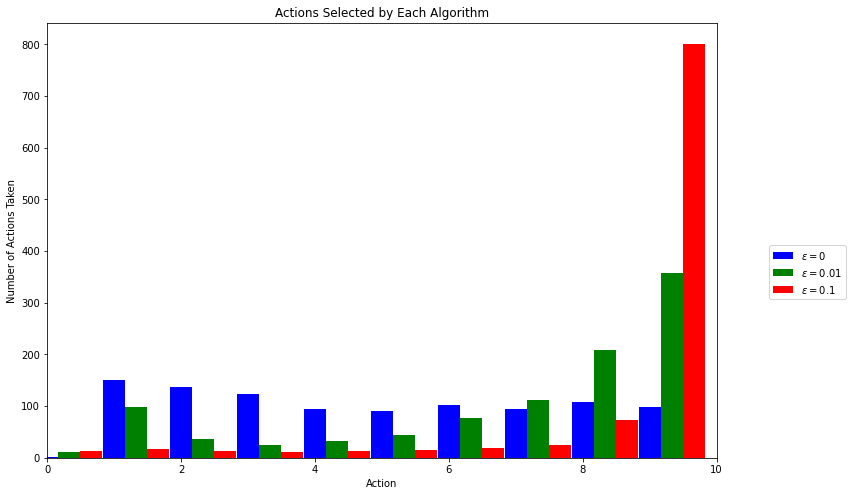

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,0.0986,15.0551,13.7472,12.2991,9.4000,9.0000,10.3000,9.4000,10.8000,9.9000
$\epsilon=0.01$,1.0743,9.7359,3.6334,2.4163,3.3122,4.3832,7.7189,11.1709,20.7732,35.7817
$\epsilon=0.1$,1.3128,1.6551,1.2782,1.2007,1.3404,1.4410,1.9344,2.4281,7.2923,80.1170


In [13]:
bins = np.linspace(0, k-1, k)

plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, 
        width = 0.33, color='b', 
        label="$\epsilon=0$")
plt.bar(bins+0.33, eps_01_selection,
        width=0.33, color='g', 
        label="$\epsilon=0.01$")
plt.bar(bins+0.66, eps_1_selection, 
        width=0.33, color='r',
        label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([eps_0_selection, eps_01_selection,
                   eps_1_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', 
    '$\epsilon=0.01$', '$\epsilon=0.1$'],
                 columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

Viewing the average selection of the algorithms, we see why the larger ϵ value performs well, it takes the optimal selection 80% of the time.

Play around with the different values of both ϵ and k to see how these results change. For example, decreasing the search space would likely benefit smaller values of ϵ as exploration would be less beneficial and vice versa. <b>Additionally, increasing the number of iterations will begin to benefit the lower value of ϵ because it will have less random noise</b>.

<a id='sect2_2'></a>
### <font color='darkgreen'>ϵ-Decay Strategies</font>
<b><font size='3ptx'>The ϵ-greedy strategies have an obvious weakness in that they continue to include random noise no matter how many examples they see. </font></b>  It would be better for these to settle on an optimal solution and continue to exploit it.

To this end, we can introduce ϵ-decay which <b>reduces the probability of exploration with every step. This works by defining `ϵ` as a function of the number of steps  `n`</b>.
![epison as function](https://miro.medium.com/max/640/1*OHcZPVCqG3dqIVFtpv7B-Q.png)

<b>Where $β<1$ is introduced as a scaling factor to reduce the scaling rate so that the algorithm has sufficient opportunity to explore</b>. In this case, we also include +1 in the denominator to prevent infinities from appearing. Given this, we can make a few small changes to our previous class of bandits to define an eps_decay_bandit class that works on the same principles.
```python
class EPSDecayBandit:
  '''
  epsilon-decay k-bandit problem

  Attributes:
    k: number of arms (int)
    iters: number of steps (int)
    karms_bandit_machine: K-arms bandit macihne.
  '''
```

Now running the code:

In [14]:
import matplotlib.pyplot as plt

def calculate_eps(beta: int = 1, n: int = 1):
    return 1 / (1 + beta * n)

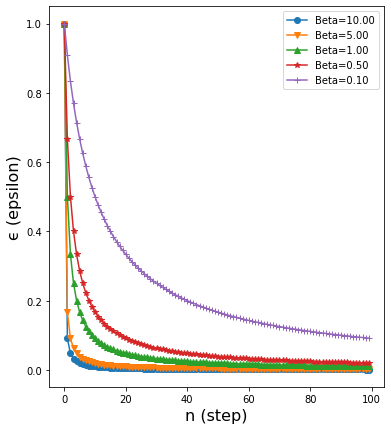

In [15]:
plt.rcParams['figure.figsize'] = [6, 7]
for beta, m in zip([10, 5, 1, 0.5, 0.1], ['o', 'v', '^', '*', '+']):
    plt.plot(
        list(range(100)),
        list(map(lambda n: calculate_eps(beta, n), range(100))),
        marker=m,
        label=f'Beta={beta:.02f}')

plt.xlabel('n (step)', fontsize=16)
plt.ylabel('ϵ (epsilon)', fontsize=16)
plt.legend()
plt.show()

In [16]:
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

karm_bandit_machine = rl_bandit_utils.KArmsBandit(k, mu='random')

# Initialize bandits
eps_decay = rl_bandit_utils.EPSDecayBandit(iters=iters, karms_bandit_machine=karm_bandit_machine)
eps_1 = rl_bandit_utils.EPSBandit(eps=0.1,iters=iters, karms_bandit_machine=karm_bandit_machine)

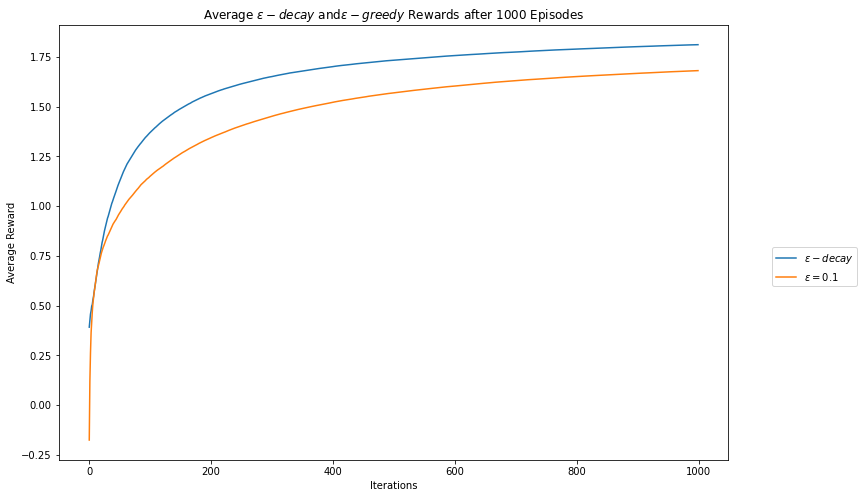

CPU times: user 14.6 s, sys: 192 ms, total: 14.8 s
Wall time: 14.5 s


In [17]:
%%time
# Run experiments
for i in range(episodes):
    # Run experiments
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
    # Reset
    eps_decay.reset()
    eps_1.reset()
    
plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and" + 
    "$\epsilon-greedy$ Rewards after " 
    + str(episodes) + " Episodes")
plt.show()

<b>The ϵ-decay strategy outperforms our previous best algorithm as it sticks to the optimal action once it is found.</b>

There’s one last method to balance the explore-exploit dilemma in k-bandit problems, <b><font size='3ptx' color='darkblue'>optimistic initial values</font></b>.

<a id='sect2_3'></a>
### <font color='darkgreen'>Optimistic Initial Value</font>
<b><font size='3ptx'>This approach differs significantly from the previous examples we explored because it does not introduce random noise to find the best action, `A*_n`. Instead, we over estimate the rewards of all the actions and continuously select the maximum.</font></b>

<b>In this case, the algorithm explores early on as it seeks to maximize its returns while additional information allows the values to converge to their true means</b>.This approach does require some additional background knowledge to be included in the set up because we need at least some idea of what the rewards are so that we can over estimate them.

For this implementation, we don’t need a new class. Instead, we can simply use our <b><font color='blue'>EPSBandit</font></b> class and set `ϵ=0` and provide high, initial values for the estimates. Also, I like to initialize the pull count for each arm as 1 instead of 0 to encourage slightly slower convergence and ensure good exploration.

In [18]:
episodes = 500

oiv_rewards = np.zeros(iters)
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Initialize K-arms bandit machine
# karm_bandit_machine = rl_bandit_utils.KArmsBandit(k, mu='sequence')
karm_bandit_machine = rl_bandit_utils.KArmsBandit(
    k=k, mu=[-1, -0.1, -0.2, -0.3, 4, -0.5, -0.6, -0.7, -0.8, -0.9])

# Initialize bandits
oiv_init = np.repeat(5., k) # Select initial values
oiv_bandit = rl_bandit_utils.EPSBandit(
    eps=0, iters=iters, karms_bandit_machine=karm_bandit_machine) # ϵ=0
oiv_bandit.k_reward = oiv_init.copy()
oiv_bandit.k_n = np.ones(k)

eps_decay = rl_bandit_utils.EPSDecayBandit(
    iters=iters, karms_bandit_machine=karm_bandit_machine)
eps_1 = rl_bandit_utils.EPSBandit(
    eps=0.1, iters=iters, karms_bandit_machine=karm_bandit_machine)

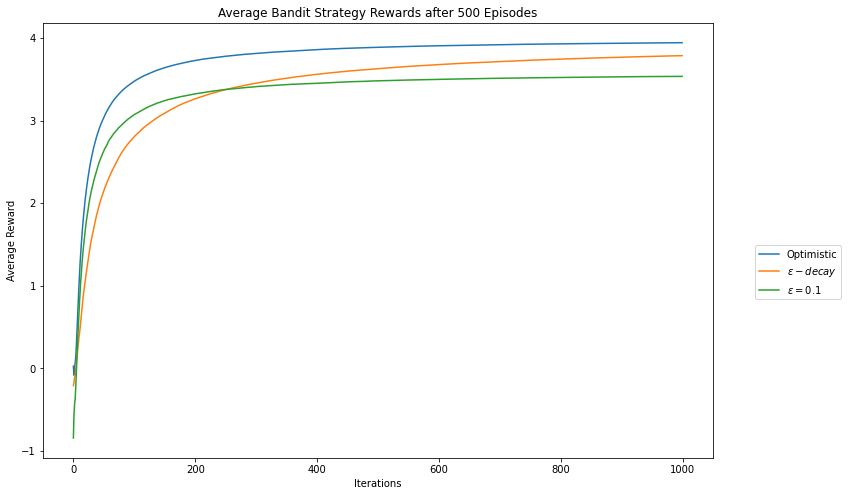

CPU times: user 10.6 s, sys: 180 ms, total: 10.7 s
Wall time: 10.5 s


In [19]:
%%time
# Run experiments
def is_last_episode(i):
    return i + 1 == episodes

for i in range(episodes):
  # Run experiments
  oiv_bandit.run()
  eps_decay.run()
  eps_1.run()
    
  # Update long-term averages
  oiv_rewards = oiv_rewards + (
      oiv_bandit.reward - oiv_rewards) / (i + 1)
  eps_decay_rewards = eps_decay_rewards + (
      eps_decay.reward - eps_decay_rewards) / (i + 1)
  eps_1_rewards = eps_1_rewards + (
      eps_1.reward - eps_1_rewards) / (i + 1)
    
  # Only reset agent when not last episode
  if not is_last_episode(i):
    oiv_bandit.reset()
    eps_decay.reset()
    eps_1.reset()
    
  
plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Bandit Strategy Rewards after " + 
    str(episodes) + " Episodes")
plt.show()

<b>We can see that, in this case, the optimistic initial value approach outperformed both our ϵ−greedy and the ϵ−decay algorithms</b>. We can see too, the estimates the algorithm has for each of arms in the last episode.

In [20]:
df = pd.DataFrame({
  "number of selections": oiv_bandit.k_n,
  "actual reward": oiv_bandit.karms_bandit_machine.mu,
  "estimated reward": oiv_bandit.k_reward})
df = df.applymap(lambda x: np.round(x, 2))
df['number of selections'] = df['number of selections'].astype('int')
df

,number of selections,actual reward,estimated reward
0,1,-1.0,-0.43
1,35,-0.1,-0.01
2,1,-0.2,-0.35
3,1,-0.3,-1.22
4,962,4.0,4.04
5,0,-0.5,0.00
6,0,-0.6,0.00
7,0,-0.7,0.00
8,0,-0.8,0.00
9,0,-0.9,0.00


The estimates are far off the actual rewards in all cases except the one with 983 pulls. This highlights a lot of what we’ll be doing in reinforcement learning more generally. <b>We don’t necessarily care about acquiring accurate representations of the environment we are interacting with. Instead, we intend to learn optimal behavior in those situations and seek to behave accordingly</b>. This can open up a whole discussion about model-free versus model-based learning that we’ll have to postpone for another time.

There are other [bandit methods](https://www.datahubbs.com/multi-armed-bandits-reinforcement-learning-2/) that we will explore such as the gradient bandits, upper confidence bound (<font color='brown'>UCB</font>) methods, and nonstationary problems. Plus, many others like [dueling bandits](http://www.sciencedirect.com/science/article/pii/S0022000012000281?via%3Dihub), [cluster bandits](https://arxiv.org/abs/1401.8257), [collaborative filtering bandits](https://arxiv.org/abs/1502.03473), [spatially correlated bandits](http://www.biorxiv.org/content/biorxiv/early/2017/04/28/106286.full.pdf), [distributed bandtis](https://arxiv.org/abs/1604.07706), [adversarial bandits](http://mercurio.srv.dsi.unimi.it/~cesabian/Pubblicazioni/J18.pdf), and [contextual bandits](http://proceedings.mlr.press/v32/agarwalb14.pdf) which are open to exploration.

## <font color='darkblue'>Supplement</font>
* [Reinforcement Learning Self-Study Course](https://developers.google.com/machine-learning/reinforcement-learning?hl=en)
* [Udemy - Artificial Intelligence: Reinforcement Learning in Python](https://www.udemy.com/course/artificial-intelligence-reinforcement-learning-in-python/learn/lecture/18855662#overview)
* [簡介 Markov Decision Process 與其應用](https://blog.techbridge.cc/2018/10/27/intro-to-mdp-and-app/)
* [Medium - Bellman Equation and dynamic programming](https://medium.com/analytics-vidhya/bellman-equation-and-dynamic-programming-773ce67fc6a7)
* [【機器學習2021】概述增強式學習 (Reinforcement Learning, RL) (一) ](https://www.youtube.com/watch?v=XWukX-ayIrs)
* [什么是 Q Learning (Reinforcement Learning 强化学习)](https://www.youtube.com/watch?v=HTZ5xn12AL4)
* [Hung-yi lee - DRL Lecture 3: Q-learning (Basic Idea)](https://www.youtube.com/watch?v=o_g9JUMw1Oc)